In [19]:
# Import modules and packages
import numpy as np
import pandas as pd
import itertools
import os, stat, time
from os.path import dirname as up

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.metrics import categorical_crossentropy
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import *
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD

from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix

from vb100_utils import *
from shutil import copyfile
import shutil
import glob
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
!pip install sklearn
!pip install -U matplotlib
!pip install Pillow

Requirement already up-to-date: matplotlib in c:\users\adity\anaconda3\envs\cheat\lib\site-packages (3.3.2)


In [3]:
print('Tensorflow version = {}'.format(tf.__version__))
print('Keras version = {}'.format(keras.__version__))

Tensorflow version = 2.3.0
Keras version = 2.4.3


<b># Data Pre-processing automatically</b>

In [4]:
# Data Folder System: -------------------------------------------------
# data
# -- test (234 + 390 = 624)
# ---- NORMAL
# ------ IM-0001-0001.jpeg
# ------ IM-0003-0001.jpeg
# ------ (234 images)
# ---- PNEUMONIA
# ------ person1_virus_6.jpeg
# ------ person109_bacteria_526.jpeg
# ------ (390 images)
# -- train (1341 + 3875 = 5216)
# ---- NORMAL
# ------ IM-0115-0001.jpeg
# ------ IM-0117-0001.jpeg
# ------ (1341 images)
# ---- PNEUMONIA
# ------ person1_bacteria_1.jpeg
# ------ person162_virus_322.jpeg
# ------ (3875 images)
# -- val (8 + 8 = 16)
# ---- NORMAL
# ------ NORMAL2-IM-1427-0001.jpeg
# ------ NORMAL2-IM-1440-0001.jpeg
# ------ (8 images)
# ---- PNEUMONIA
# ------ person1946_bacteria_4874.jpeg
# ------ person1951_bacteria_4882.jpeg
# ------ (8 images)

# In total: 234 + 390 + 3875 + 8 + 8 = 4515 imges (1.2GB of data)
# -----------------------------------------------------------------------

<img src="imgs/01.jpeg" alt="Folder system" width="550">

In [5]:
# CONSTANTS FOR DIRECTORIES
TRAIN_DIR = 'Dataset/train'
VALID_DIR = 'Dataset/val'
TEST_DIR = 'Dataset/test'
l_DIRS = [TRAIN_DIR, VALID_DIR, TEST_DIR]
POSITIVE_CLASS = 'NORMAL'
ABSTRACT_CLASS = 'COVID'

# CONSTANTS FOR IMAGE PARAMETERS
INPUT_W = 1200 # pixels
INPUT_H = 900  # pixels
DIVIDER = 3.6
INPUT_DIM = (int(INPUT_W/DIVIDER), int(INPUT_H/DIVIDER), 1)
BATCH_SIZE_TRAIN = 36
BATCH_SIZE_TEST = 15 
BATCH_SIZE_VALID = 2
NORMALIZER = 1./255
IMAGE_FORMAT = 'jpeg'

# Output Info
print('Image dimmensions for CNN = {}'.format(INPUT_DIM))

Image dimmensions for CNN = (333, 250, 1)


In [6]:
if abstract_class_exists(ABSTRACT_CLASS, l_DIRS):
    structure_origin_data(l_DIRS, IMAGE_FORMAT, POSITIVE_CLASS)

classes = classes_for_each_set(l_DIRS)

print('Catched classes for the model:\n{}'.format(classes))

Performing raw data restructuring. Please wait.

Current Working Directory: D:\ADITYA\projects\hackchennai\model

*** Handling workspace: Dataset/train ***
| Folders found:
|| ['D:\\ADITYA\\projects\\hackchennai\\model/Dataset/train\\COVID', 'D:\\ADITYA\\projects\\hackchennai\\model/Dataset/train\\NORMAL']

| Entering to: D:\ADITYA\projects\hackchennai\model/Dataset/train\COVID
||| Unique Classes Found: ['NORMAL']
||| Files found in total: 300
--> NORMAL = 300
|||--> Filelist for NORMAL is created.

| Entering to: D:\ADITYA\projects\hackchennai\model/Dataset/train\NORMAL
||| Unique Classes Found: ['NORMAL']
||| Files found in total: 300
--> NORMAL = 300
|||--> Filelist for NORMAL is created.

*** Handling workspace: Dataset/val ***
| Folders found:
|| ['D:\\ADITYA\\projects\\hackchennai\\model/Dataset/val\\COVID', 'D:\\ADITYA\\projects\\hackchennai\\model/Dataset/val\\NORMAL']

| Entering to: D:\ADITYA\projects\hackchennai\model/Dataset/val\COVID
||| Unique Classes Found: ['NORMAL']
||

Found 600 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


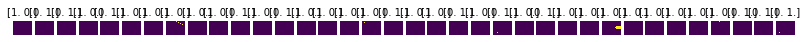

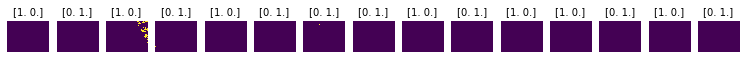

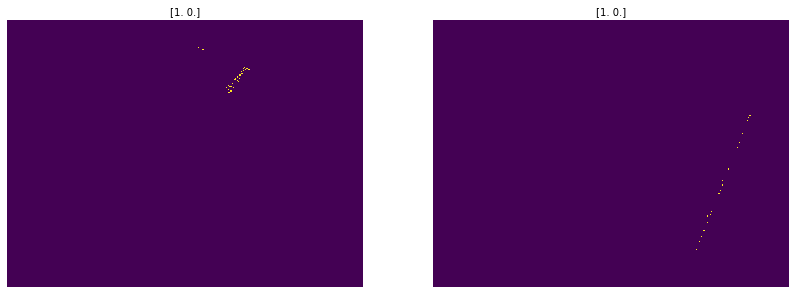

In [7]:
# Generating and Plot Image Data from Train Set
TRAIN_BATCHES = ImageDataGenerator(rescale=NORMALIZER).\
    flow_from_directory(TRAIN_DIR,
    color_mode='grayscale',
    target_size=INPUT_DIM[0:2],
    classes=classes['TRAIN'],
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE_TRAIN)

imgs, labels = next(TRAIN_BATCHES)  # <-- Extracting image matrixes and labels
plots(imgs, titles=labels)          # <-- Plot Images with labels
#train_imgs = rgb_to_grayscale(imgs) # <-- Convert RGB images to Grayscale ones by Tensorflow
#train_labels = labels

# Generating and Plot Image Data from Test Set
TEST_BATCHES = ImageDataGenerator(rescale=NORMALIZER).\
    flow_from_directory(TEST_DIR,
    color_mode='grayscale',
    target_size=INPUT_DIM[0:2],
    classes=classes['TEST'],
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE_TEST)

imgs, labels = next(TEST_BATCHES)   # <-- Extracting image matrixes and labels
plots(imgs, titles=labels)          # <-- Plot Images with labels
#test_imgs = rgb_to_grayscale(imgs)  # <-- Convert RGB images to Grayscale ones by Tensorflow
#test_labels = labels

# Generating and Plot Image Data from Validation Set
VAL_BATCHES = ImageDataGenerator(rescale=NORMALIZER).\
    flow_from_directory(VALID_DIR,
    color_mode='grayscale',
    target_size=INPUT_DIM[0:2],
    classes=classes['VALIDATION'],
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE_VALID)

imgs, labels = next(VAL_BATCHES)   # <-- Extracting image matrixes and labels
plots(imgs, titles=labels)         # <-- Plot Images with labels
#val_imgs = rgb_to_grayscale(imgs)  # < -- Convert RGB images to Grayscale ones by Tensorflow
#val_labels = labels

In [8]:
# Output of Generators
for data_batch, label_batch in TRAIN_BATCHES:
    print('data batch shape = {}'.format(data_batch.shape))
    print('labels batch shape = {}'.format(label_batch.shape))
    break

data batch shape = (36, 333, 250, 1)
labels batch shape = (36, 2)


<b># Build CNN with Keras</b>

In [9]:
from keras.regularizers import l2
# Build the CNN model
model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=(INPUT_DIM)))
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3)))

model.add(Conv2D(128, (4, 4))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (2, 2))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 

 
model.add(Activation('relu'))

model.add(Dense(2)) 
model.add(Activation('softmax')) 

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 329, 246, 64)      1664      
_________________________________________________________________
activation (Activation)      (None, 329, 246, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 82, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 79, 128)      131200    
_________________________________________________________________
activation_1 (Activation)    (None, 106, 79, 128)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 39, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 37, 512)       5

In [11]:
# Define an optimizer for the model
opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#opt = SGD(lr=0.01, decay=1e-6, momentum=0.85, nesterov=True)
#opt = RMSprop(lr=0.001, rho=0.8, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [12]:
print('steps_per_epoch={}'.format(int(600 / BATCH_SIZE_TRAIN)))
print('validation_steps={}'.format(int(50 / BATCH_SIZE_TEST)))

steps_per_epoch=16
validation_steps=3


<b># Train the CNN with Training data</b>

In [14]:
%%time
model.fit_generator(
    TRAIN_BATCHES,
    steps_per_epoch=len(TRAIN_BATCHES),
    validation_data=TEST_BATCHES,
    validation_steps=len(TEST_BATCHES),
    epochs=100,
    verbose=2
)

# Parameters meanings:
# steps_per_epoch = number_of_images / batch_size = 5215 / 64 = 82:
# --- Total number of steps (batches of samples) to yield from generator before declaring one 
#     epoch finished and starting the next epoch. It should typically be equal to the number 
#     of unique samples of your dataset divided by the batch size.
# Verbose:
# -- 0 (quiet): you just get the total numbers of tests executed and the global result
# -- 1 (default): you get the same plus a dot for every successful test or a F for every failure
# -- 2 (verbose): you get the help string of every test and the result

Epoch 1/100
17/17 - 78s - loss: 0.6749 - accuracy: 0.5533 - val_loss: 0.6682 - val_accuracy: 0.5200
Epoch 2/100
17/17 - 79s - loss: 0.6655 - accuracy: 0.6667 - val_loss: 0.6545 - val_accuracy: 0.6400
Epoch 3/100
17/17 - 77s - loss: 0.6500 - accuracy: 0.6550 - val_loss: 0.6337 - val_accuracy: 0.7600
Epoch 4/100
17/17 - 78s - loss: 0.6284 - accuracy: 0.8067 - val_loss: 0.6037 - val_accuracy: 0.7800
Epoch 5/100
17/17 - 79s - loss: 0.6000 - accuracy: 0.7667 - val_loss: 0.5684 - val_accuracy: 0.7200
Epoch 6/100
17/17 - 81s - loss: 0.5505 - accuracy: 0.8400 - val_loss: 0.5044 - val_accuracy: 0.8600
Epoch 7/100
17/17 - 79s - loss: 0.4978 - accuracy: 0.8317 - val_loss: 0.4347 - val_accuracy: 0.8600
Epoch 8/100
17/17 - 82s - loss: 0.4397 - accuracy: 0.8317 - val_loss: 0.3773 - val_accuracy: 0.9000
Epoch 9/100
17/17 - 78s - loss: 0.4143 - accuracy: 0.8250 - val_loss: 0.3402 - val_accuracy: 0.8800
Epoch 10/100
17/17 - 77s - loss: 0.3746 - accuracy: 0.8450 - val_loss: 0.3775 - val_accuracy: 0.8000

Epoch 83/100
17/17 - 71s - loss: 0.0834 - accuracy: 0.9700 - val_loss: 0.0525 - val_accuracy: 1.0000
Epoch 84/100
17/17 - 72s - loss: 0.0798 - accuracy: 0.9767 - val_loss: 0.0483 - val_accuracy: 1.0000
Epoch 85/100
17/17 - 78s - loss: 0.0727 - accuracy: 0.9750 - val_loss: 0.0449 - val_accuracy: 1.0000
Epoch 86/100
17/17 - 80s - loss: 0.0695 - accuracy: 0.9783 - val_loss: 0.0497 - val_accuracy: 1.0000
Epoch 87/100
17/17 - 75s - loss: 0.0744 - accuracy: 0.9783 - val_loss: 0.0744 - val_accuracy: 0.9600
Epoch 88/100
17/17 - 75s - loss: 0.0781 - accuracy: 0.9783 - val_loss: 0.0918 - val_accuracy: 0.9600
Epoch 89/100
17/17 - 72s - loss: 0.0963 - accuracy: 0.9633 - val_loss: 0.0510 - val_accuracy: 1.0000
Epoch 90/100
17/17 - 77s - loss: 0.1036 - accuracy: 0.9667 - val_loss: 0.0547 - val_accuracy: 0.9800
Epoch 91/100
17/17 - 77s - loss: 0.0957 - accuracy: 0.9683 - val_loss: 0.0605 - val_accuracy: 0.9800
Epoch 92/100
17/17 - 76s - loss: 0.0683 - accuracy: 0.9783 - val_loss: 0.0411 - val_accurac

In [22]:
#-------------------------------------------------------------------------------#
# Module dedicated to Pneumonia Detection on Keras Model                        #
# Part: Main functions and Procedures                                           #
# Date of preparation: 2019 07 16–26                                            #
# © Vytautas Bielinskas                                                         #
#-------------------------------------------------------------------------------#


#-------------------------------------------------------------------------------#
# Import modules and packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 
import time, datetime, os, stat, glob, shutil, itertools
import itertools
from pylab import rcParams
from os.path import dirname as up
from PIL import Image
from shutil import copyfile
from datetime import date


#-------------------------------------------------------------------------------#
# Plot Raw Image Data
def plots(ims, figsize=(14, 7.5), rows=1, interp=False, titles=None):
    '''
    Args:	
        -- ims : given list of images (list)
        -- figsize : wanted size of plotting images (width and height)
        -- rows : wanted rows to be ploted per one request
    '''

    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1

    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=10)
        plt.imshow(ims[i].squeeze(), interpolation=None if interp else 'none')


#-------------------------------------------------------------------------------#
# If Any Issues caused by non-readable directories
def on_rm_error(func, path, exc_info):
    '''
    Given path contains the path of the file that couldn't be removed
    let's just assume that it's read-only and unlink it.
    '''

    os.chmod(path, stat.S_IWRITE)
    os.unlink(path)

    return None


#-------------------------------------------------------------------------------#
# Delete files in a single folder
def delete_files_in_folder(folder_path):
    '''
    Args:
        -- folder_path : a given URL to folder contains any content
    '''

    os.chmod(folder_path, 0o777)
    print('given folder address: {}'.format(folder_path))
    shutil.rmtree(folder_path, onerror = on_rm_error)
    print('folder deleted.')

    return None


#-------------------------------------------------------------------------------#
# Rename folder by a given folder name in given full URLs
def rename_folder_with_single_class(current_folder_path, renamed_folder_path):
    '''
        -- folder_path : a given URL to folder contains any content    
    '''

    os.rename(current_folder_path, renamed_folder_path)
    print('Directory for single class has been changed from\
    {} to {}'.format(current_folder_path, renamed_folder_path))
    
    return None


#-------------------------------------------------------------------------------#
# Check if Abstract class folder is in any project subdirectory
def abstract_class_exists(ABSTRACT_CLASS, l_DIRS):
	'''
		-- ABSTRACT_CLASS : name of abstract class which must be splited after.
		-- l_DIRS : list of train, test and val. sets for the project.
	'''

	l_subs = []
	for folder in l_DIRS:
	    subfolders = [f.name for f in os.scandir(folder) if f.is_dir()]

	    l_subs.append(subfolders)
	# Concat separate list of folders (list of lists) to single vector
	l_subs = [folder for folders in l_subs for folder in folders]

	response = ABSTRACT_CLASS in l_subs

	if response:
		print('Performing raw data restructuring. Please wait.\n')
	else:
		print('Data are valid and ready to be feeded to the model already.\n')

	return response


#-------------------------------------------------------------------------------#
# Get list of classes for each set
def classes_for_each_set(l_DIRS):
	'''
		-- l_DIRS : list of train, test and val. sets for the project.
	'''

	d = {} # Reserved space for a single list of classes within set (dictionary)
	for folder in l_DIRS:
	    subfolders = [f.name for f in os.scandir(folder) if f.is_dir()]

	    if 'train'.upper() in folder.upper():
	    	d['TRAIN'] = subfolders

	    elif 'test'.upper() in folder.upper():
	    	d['TEST'] = subfolders

	    else:
	    	d['VALIDATION'] = subfolders

	return d


#-------------------------------------------------------------------------------#
# Original data structuring for specific schema
def structure_origin_data(l_DIRS, IMAGE_FORMAT, POSITIVE_CLASS):
    '''
        -- l_DIRS : list of directories for training, test and val. sets.
        -- IMAGE_FORMAT : format of files to be readed.
        -- POSITIVE_CLASS : name of Positive class in the task.
    '''

    cwd = os.getcwd() # Get Current Working Directory
    print('Current Working Directory: {}'.format(cwd))

    dims_w = []
    dims_h = []

    dirs_to_delete = []

    for this_dir in l_DIRS:
        print('\n*** Handling workspace: {} ***'.format(this_dir))
        # Keep Temporary Directory
        temp_dir = '{}/{}'.format(cwd, this_dir) 
        os.chdir(temp_dir)

        # Get list of Folders in Temporary Directory
        list_folders = [f.path for f in os.scandir(temp_dir) if f.is_dir()]
        print('| Folders found:\n|| {}'.format(list(list_folders)))
        
        if len(list_folders) > 0:

            # Got through subfolders
            for this_folder in list_folders:
                #1. Change CWD to Subfolder
                os.chdir(this_folder)
                print('\n| Entering to: {}'.format(this_folder))
                
                classes = [] # Classes in this subfolder
                files = []   # Filelist in this Subfolder with a set Class
                
                #2. Scanning image data
                for image_file in glob.glob('*.{}'.format(IMAGE_FORMAT)):
                    
                    d = {} # Temporary Data for a Single Image in Subfolder
                    
                    #3. Open Image to Extract Data
                    with Image.open(image_file) as opened_image:    # Open Image file
                        opened_image_dims = opened_image.size       # Extract Dimmensions
                        opened_image.close()                        # Close Image File
                    
                    #4. Identify the Class (label)
                    if '_' in image_file:
                        this_class = image_file.upper().split('_')[1].split('_')[0].replace(' ', '')
                    else:
                        this_class = POSITIVE_CLASS

                    classes.append(this_class)
                    
                    #5. Assign file to the Class
                    d['Class'] = this_class
                    d['Filename'] = image_file
                    files.append(dict(d))
                    
                    #6. Add Dimensions to lists
                    dims_w.append(opened_image_dims[0])
                    dims_h.append(opened_image_dims[1])
                    
                #7. Get Unique Classes in Scanned Subfolder
                unique_classes = list(set(classes))
                files_df = pd.DataFrame(files)

                print('||| Unique Classes Found: {}'.format(unique_classes))
                print('||| Files found in total: {}'.format(len(files)))

                for this_class, i in zip(unique_classes, range(0, len(unique_classes))):

                    print('--> {} = {}'.format(this_class, len(files_df[files_df['Class'] == this_class])))
                    dir_for_class = '{}/{}'.format(temp_dir, this_class)

                    #8. Generate List of Files to be Moved
                    filelist = list(files_df[files_df['Class']==this_class]['Filename'])
                    print('|||--> Filelist for {} is created.'.format(this_class))

                    # Make a Copy in Level Up Folder
                    #9. Create a Special Folder for A Specifed Class in Parent Folder
                    os.chdir(temp_dir)
                    
                    if len(unique_classes) > 1:
                        try:  

                            os.mkdir(dir_for_class)
                            print('|||| Successfully created the directory for {} on {}'.format(this_class, dir_for_class))

                        except OSError:

                            print('!!!! Creation of the directory {} failed.'.format(dir_for_class))

                        os.chdir(this_folder)
                        for f in filelist:
                            shutil.copy(f, dir_for_class)

                        #11. Add Current Folder to the list for Deleting
                        dirs_to_delete.append(this_folder)
                        
                    elif (len(unique_classes) == 1) and (unique_classes[0].upper() != POSITIVE_CLASS.upper()):
                        dir_for_class = '{}/{}'.format(temp_dir, unique_classes[0].upper())
                        rename_folder_with_single_class(this_folder, dir_for_class)
                                      
    #12. Deleting Used Directories
    time.sleep(5)
    os.chdir(cwd)
    for deleting in set(dirs_to_delete):

        print('\n--> Deleting Folder: {}'.format(deleting))
        delete_files_in_folder(deleting)
            
    print('*** All Used Folders have been removed from the system. ***')
                
    # Averaging Dimmensions of Scanned Images
    avg_dims_w = int(np.average(dims_w))
    avg_dims_h = int(np.average(dims_h))
    print('\n: Average Image Width = {}'.format(avg_dims_w))
    print(': Average Image Height = {}'.format(avg_dims_h))

    return None


#-------------------------------------------------------------------------------#
# Plot Result Graph for Accuracy, Loss and Validation
def plot_model_result(model):
	'''
		-- model : Keras model.
	'''

	rcParams['figure.figsize'] = 14, 4 # Set plot size

	# Plot #1

	y1 = model.history.history['val_accuracy']
	y2 = model.history.history['accuracy']

	_ = plt.title('Model Results', family='Arial', fontsize=12)

	_ = plt.plot(y1, 
		color='blue', linewidth=1.5, marker='D', markersize=5,
		label='Validation acc.')
	_ = plt.plot(y2, 
		color='#9999FF', linewidth=1.5, marker='D', markersize=5,
		label='Training acc.')

	_ = plt.xlabel('Epochs', family='Arial', fontsize=10)
	_ = plt.ylabel('Score', family='Arial', fontsize=10)

	_ = plt.yticks(np.arange(0., 1.25, 0.1),
				   family='Arial', fontsize=10)

	if len(model.history.history['accuracy']) < 51:
		_ = plt.xticks(np.arange(0, len(model.history.history['accuracy']), 1),
					   family='Arial', fontsize=10)

	_ = plt.ylim((0., 1.))

	_ = plt.fill_between(np.arange(0, len(model.history.history['accuracy']), 1),
						 model.history.history['accuracy'], 0,
						 color = '#cccccc', alpha=0.5)

	_ = plt.grid(which='major', color='#cccccc', linewidth=0.5)
	_ = plt.legend(loc='best', shadow=True)
	_ = plt.margins(0.02)

	_ = plt.show()

	# Plot #2
	_ = plt.clf()

	_ = plt.plot(model.history.history['val_loss'], 
		color='red', linewidth=1.5, marker='D', markersize=5,
		label='Validation loss')
	_ = plt.plot(model.history.history['loss'], 
		color='#FF7F7F', linewidth=1.5, marker='D', markersize=5,
		label='Loss')

	_ = plt.xlabel('Epochs', family='Arial', fontsize=10)
	_ = plt.ylabel('Loss score', family='Arial', fontsize=10)

	if len(model.history.history['accuracy']) < 51:
		_ = plt.xticks(np.arange(0, len(model.history.history['accuracy']), 1),
					   family='Arial', fontsize=10)
	_ = plt.yticks(family='Arial', fontsize=10)

	_ = plt.grid(which='major', color='#cccccc', linewidth=0.5)
	_ = plt.legend(loc='best', shadow=True)
	_ = plt.margins(0.02)

	_ = plt.show()

	return None


#-------------------------------------------------------------------------------#
# Convert RGB Images to Grayscale Images
def rgb_to_grayscale(imgs_set):
	'''
		-- imgs_set : set of RGB images (3 channels)
	'''

	return tf.image.rgb_to_grayscale(imgs_set, name=None)


#-------------------------------------------------------------------------------#
# Save Model Result to Pandas DataFrame and then to CSV file
def save_model_result(model):
	'''
		-- model : compiled model on the given data.
	'''

	# Extract model result data to separate data vectors
	data_val_acc = list(model.history.history['val_accuracy'])
	data_acc = list(model.history.history['accuracy'])
	data_val_loss = list(model.history.history['val_loss'])
	data_loss = list(model.history.history['loss'])

	# Convert Model result data to dataframe by using dictionary dat structure
	d = {}
	d['val_accuracy'] = data_val_acc
	d['accuracy'] = data_acc
	d['val_loss'] = data_val_loss
	d['loss'] = data_loss

	df = pd.DataFrame(d)
	print(df)

	# Get a current timestamp
	timestamp = str(datetime.datetime.now()).replace(":","-")[:-10].replace(' ', '_')
	filename = 'model_results_{}.csv'.format(timestamp)
	df.to_csv(filename, encoding='utf-8')

	print('\n\nResult data is saved as file: {}'.format(filename))

	return df

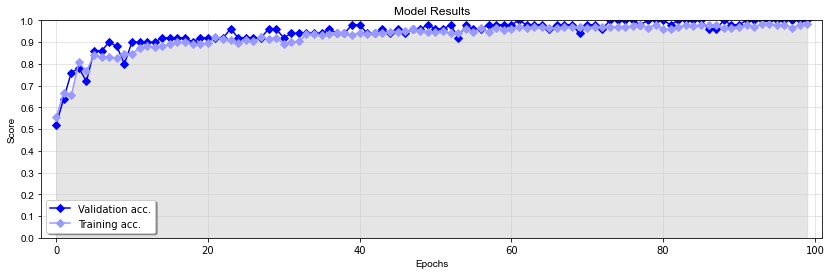

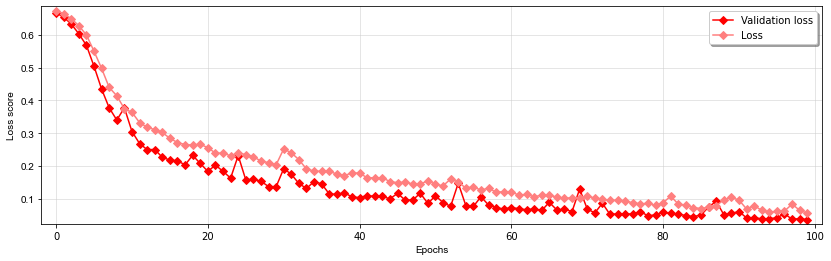

In [23]:
plot_model_result(model)

<p><i>More saved models are stored on the project directory as <code>good_models</code>. There are subsystem contain graphs, weights and CNN architectures for each training experiment.</i></p>

In [24]:
# Save the results as separate lists
df = save_model_result(model)

    val_accuracy  accuracy  val_loss      loss
0           0.52  0.553333  0.668229  0.674884
1           0.64  0.666667  0.654530  0.665536
2           0.76  0.655000  0.633743  0.650007
3           0.78  0.806667  0.603654  0.628444
4           0.72  0.766667  0.568423  0.600044
..           ...       ...       ...       ...
95          1.00  0.980000  0.041121  0.061446
96          1.00  0.980000  0.053772  0.062065
97          1.00  0.966667  0.036845  0.082974
98          1.00  0.978333  0.038718  0.064303
99          1.00  0.983333  0.035735  0.055467

[100 rows x 4 columns]


Result data is saved as file: model_results_2020-09-19_14-04.csv


<h3>Part 2. Make it resuable</h3>

In [25]:
# Save the Model Weights
model.save_weights('model_pathology_covid_weights.h5')

# Save the Model to JSON
model_json = model.to_json()
with open('model_pathology_covid.json', 'w') as json_file:
    json_file.write(model_json)
    
print('Model saved to the disk.')

Model saved to the disk.


In [17]:
# Useful references:
# -- https://www.youtube.com/watch?v=daovGOlMbT4
# -- https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/

In [26]:
# ------------------------------------------------------------------------
# Load saved model and its weights
'''
>> Model weights are saved to HDF5 format.
>> The model structure can be described and saved using two different formats: JSON and YAML.
'''

# Import dependencies
from keras.optimizers import Adam
from tensorflow.keras.models import model_from_json
from tensorflow.python.framework import ops
ops.reset_default_graph()
import h5py 
from PIL import Image
import PIL
from vb100_utils import *

In [27]:
print('h5py version is {}'.format(h5py.__version__))

h5py version is 2.10.0


In [28]:
# Get the architecture of CNN
json_file = open('D:/ADITYA/projects/hackchennai/model/good_model/model_pathology_covid.json')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Get weights into the model
loaded_model.load_weights('D:/ADITYA/projects/hackchennai/model/good_model/model_pathology_covid_weights.h5')

In [50]:
'''
Here I will simulate what will happen during deployment on a cloud.
Reading a given image, preparing it for CNN evaluation and make
a predictions with a returned class from a dictionary that has
been used for training.
'''

# Define optimizer and run
opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
loaded_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')


'''
Important Note! For this block optimizer is entered manualy as Tensorflow object.
For future, need to change it for include it as variable with full set of
parameters as Tensorflow variable.

'''

IMG = Image.open('C:\\Users\\adity\\Desktop\\test.jpg')
print(type(IMG))
IMG = IMG.resize((333, 250))
IMG = np.array(IMG)
print('po array = {}'.format(IMG.shape))
IMG = np.true_divide(IMG, 255)
IMG = IMG.reshape(3, 333, 250, 1)
print(type(IMG), IMG.shape)

predictions = loaded_model.predict(IMG)

print(loaded_model)
predictions_c = loaded_model.predict_classes(IMG)
print(predictions, predictions_c)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
po array = (250, 333, 3)
<class 'numpy.ndarray'> (3, 333, 250, 1)
[[0.99884206 0.00115792]
 [0.00890233 0.9910977 ]
 [0.04937477 0.95062524]] [0 1 1]


In [51]:
classes = {'TRAIN': ['NORMAL', 'COVID'],
           'VALIDATION':['NORMAL', 'COVID'],
           'TEST': ['NORMAL', 'COVID']}

predicted_class = classes['TRAIN'][predictions_c[0]]
print('We think that is {}.'.format(predicted_class.lower()))

We think that is normal.


<h2>That is all for Jupyter.</h2>
<p>Go to deployment stage now.</p>